# Change size of final output here

In [1]:
N_snow = 150 # Number of points for snow (needs to be bigger than 2*q2 and >= desired size along longest dimension)
xpxl_snow = 150
ypxl_snow = 100

N_grass = 200
xpxl_grass = 200
ypxl_grass = 100

#for smoothing the lateral edges (cyclic BCs)
lateralsmoothing = True
lateralpxl = 3 #linear smoothing to 0 (at boundary) done over so many pixel

#for smoothing the inflow
inflowsmoothing = True
inflowpxl = 3

#for export
xlength = 35 #m
ylength = 10 #m
stl_filename = '/home/haugened/Documents/openfoam/duerr_les/scripts/create_rough_surface/srf_xyz.stl'

#if should be cut for small trial domain, check parameters further down. Above variables are partially overriden!

In [2]:
import numpy
import matplotlib.pyplot as plt
import tamaas

from numpy import pi
from IPython.display import display, Latex
from matplotlib.colors import LogNorm

In [3]:
plt.rc('figure', dpi=100)

# Generating Rough Surfaces

*Before you begin: if you've downloaded this notebook, make sure you have the dependencies installed. `python3 -m pip install --user -r requirements.txt` should set you up nicely.*

In this notebook, we'll see how to use Tamaas to generate random, periodic rough surfaces. The algorithms in Tamaas all expect a definition of the Power Spectrum Density (PSD), although the code is very flexible and gives a lot of freedom to the user in this regard. For starters, we'll use two classes shipped with Tamaas that define two different PSD.

The first is the `tamaas.Isopowerlaw` class. It has three wavenumber parameters `q0, q1, q2` and a Hurst exponent. The second is the `tamaas.RegularizedPowerlaw` class, which has only two wavenumber parameters (and the Hurst exponent). Below is a graph showing the two power laws.

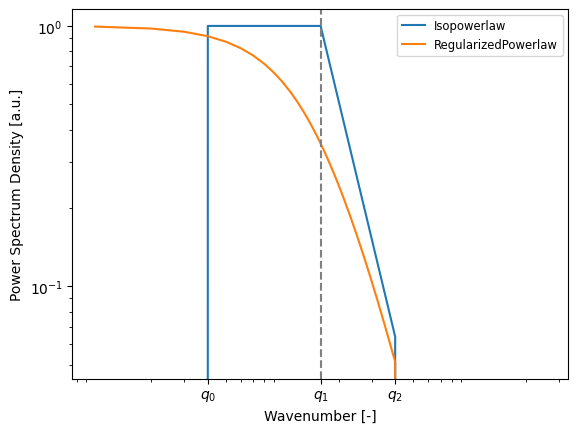

In [4]:
fig, ax = plt.subplots()

q0 = 4
q1 = 16
q2 = 40
H = 0.5

def isopowerlaw(q):
    if q < q0:
        return 0.
    elif q > q2:
        return 0.
    elif q < q1:
        return 1.
    else:
        return (q / q1)**-(2 * H + 2)
    
def regularizedpowerlaw(q):
    if q > q2:
        return 0.
    else:
        return (1 + (q / q1)**2)**-(H + 1)
    
isopowerlaw = numpy.vectorize(isopowerlaw)
regularizedpowerlaw = numpy.vectorize(regularizedpowerlaw)
    
q = numpy.arange(1, 256)

ax.plot(q, isopowerlaw(q), label='Isopowerlaw')
ax.plot(q, regularizedpowerlaw(q), label='RegularizedPowerlaw')
ax.axvline(q1, color='gray', ls='--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([q0, q1, q2])
ax.set_xticklabels(['$q_0$', '$q_1$', '$q_2$'])

ax.set_xlabel('Wavenumber [-]')
ax.set_ylabel('Power Spectrum Density [a.u.]')

ax.legend(fontsize='small')
plt.show()

The powerlaw exponent in the above graph is controlled by the Hurst exponent `H`.

## Creating the spectrum objects

Let's create a 2D surface. For that we'll need a `tamaas.Isopowerlaw2D` object and set its parameters.

In [5]:
spectrum = tamaas.Isopowerlaw2D()
spectrum.q0 = q0
spectrum.q1 = q1
spectrum.q2 = q2
spectrum.hurst = H

The `spectrum` object can be queried to know some of the asymptotic properties of surfaces generated with it. For example, we can know in advance the root-mean-square of heights or the root-mean-square of slopes.

In [6]:
rms_heights = spectrum.rmsHeights()
rms_slopes = spectrum.rmsSlopes()

display(Latex(r'$\sqrt{{\langle h^2 \rangle}} \approx {:.0f}$'.format(rms_heights)))
display(Latex(r'$\sqrt{{\langle \nabla h^2 \rangle}} \approx {:.0f}$'.format(rms_slopes)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Creating the surface generator

To generate the rough surface, we need a surface generator object. Tamaas implements two methods with two separate classes: `tamaas.SurfaceGeneratorFilter` and `tamaas.SurfaceGeneratorRandomPhase`. The former generates a surface by the product of the Fourier transform of gaussian noise and the desired surface spectrum, while the latter generates uniform random phases without altering the power spectrum. This leads to a lower variance of statistical quantities in the surfaces generated compared to `tamaas.SurfaceGeneratorFilter`, but depending on the application adding noise to the power spectrum might be a desired effect. For simplicity, let's use the `tamaas.SurfaceGeneratorRandomPhase` class.

In [7]:
generator = tamaas.SurfaceGeneratorRandomPhase2D([N_snow, N_snow])
generator.spectrum = spectrum
generator.random_seed = 41

We can easily generate a surface for the seed we specified.

In [8]:
surface = generator.buildSurface()

**Important**: the object `surface` is a *reference* to an array internal to `generator`. That means that if you change the `random_seed` or the `spectrum` and call `buildSurface()` again, the object `surface` will automatically change.

Let's plot our new surface.

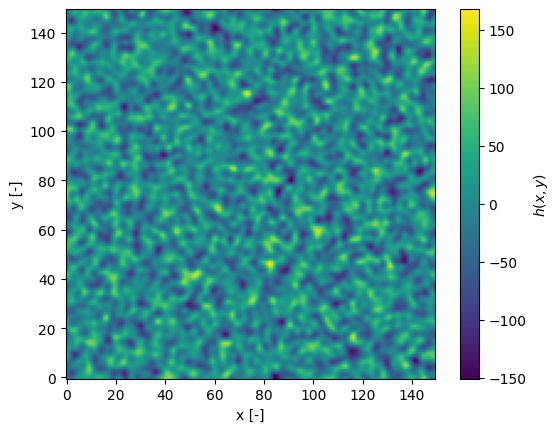

In [9]:
fig, ax = plt.subplots()

image = ax.imshow(surface, origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

## Statistical properties

We can use the class `tamaas.Statistics2D` to compute stats on our surface. For example, we can check that the values of the RMS of heights and slopes are correct (i.e. close to the theoretical value from the `spectrum`).

In [10]:
rms_heights = tamaas.Statistics2D.computeRMSHeights(surface)
rms_slopes = tamaas.Statistics2D.computeSpectralRMSSlope(surface)

display(Latex(r'$\sqrt{{\langle h^2 \rangle}} \approx {:.0f}$'.format(rms_heights)))
display(Latex(r'$\sqrt{{\langle \nabla h^2 \rangle}} \approx {:.0f}$'.format(rms_slopes)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Although some of these statistics can be computed with Numpy/Scipy, `tamaas.Statistics2D` is the prefered way to do it because it handles cases when the program is run in an MPI environment. It can also be used to compute more advanced functions, such as the power density spectrum or the autocorrelation.

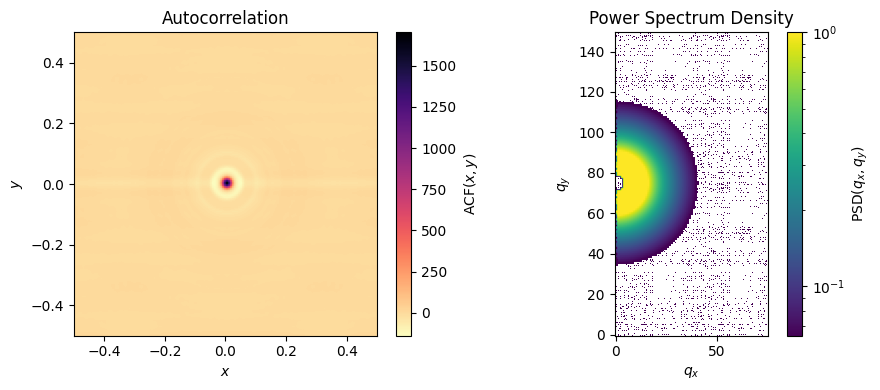

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

psd = tamaas.Statistics2D.computePowerSpectrum(surface)
acf = tamaas.Statistics2D.computeAutocorrelation(surface)

# Plot autocorrelation (we use fftshift to rearrange data)
image = axs[0].imshow(numpy.fft.fftshift(acf), extent=(-0.5, 0.5, -0.5, 0.5),
                      origin='lower', cmap='magma_r')
fig.colorbar(image, ax=axs[0]).set_label('ACF$(x, y)$')
axs[0].set_title("Autocorrelation")
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')

# We use a logarithmic color scale
norm = LogNorm(vmin=(q2 / q1)**-(2 * H + 2), vmax=1)
# Shift only along one axis due to r2c transform
image = axs[1].imshow(numpy.fft.fftshift(psd, axes=0).real,
                      origin='lower', norm=norm)
fig.colorbar(image, ax=axs[1]).set_label('PSD$(q_x, q_y)$')
axs[1].set_title('Power Spectrum Density')
axs[1].set_xlabel('$q_x$')
axs[1].set_ylabel('$q_y$')

fig.tight_layout()
plt.show()

We can look at our isotropic powerlaw in 1D by radially averaging the computed PSD with the function `tamaas.utils.radial_average`.

In [12]:
from tamaas.utils import radial_average

# Center PSD and select real values
psd_ = numpy.fft.fftshift(psd, axes=0).real

# Construct q-coordinate space
qx = numpy.arange(-psd_.shape[0] // 2, psd_.shape[0] // 2)
qy = numpy.arange(psd_.shape[1])

# Construct polar coordinates (must be within the qx x qy domain)
r = numpy.linspace(0, N_snow//2 - 1, N_snow * 2)
theta = numpy.linspace(0, numpy.pi, 100)

# Do the radial average with nearest point interpolation
psd_iso = radial_average(qx, qy, psd_, r, theta, method='nearest')

0.002307750646907946


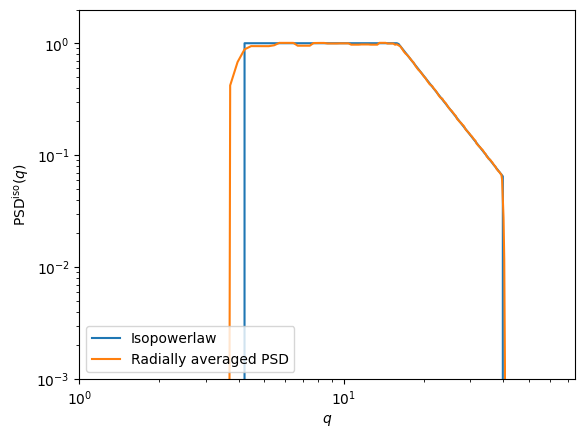

In [13]:
fig, ax = plt.subplots()

# Plot theoretical PSD
ax.loglog(r, isopowerlaw(r), label='Isopowerlaw')

# Plot averaged PSD
ax.loglog(r, psd_iso, label='Radially averaged PSD')

ax.set_xlim(1, N_snow // 2)
ax.set_ylim(1e-3, 2)

ax.set_xlabel("$q$")
ax.set_ylabel('PSD$^\\mathrm{iso}(q)$')

ax.legend()

print(numpy.mean((isopowerlaw(r)-psd_iso)**2))

plt.show()

## Normalizing a surface

Sometimes a specific value of the RMS of heights or slopes is derired for a surface. In Tamaas, these values can be enforced after the surface has been generated by normalizing with either the theoretical value (the preferred way when possible, because it is unbiased) or a value computed with `tamaas.Statistics2D`.

In [14]:
target_rms_heights = 0.020

# Normalizing the surface with theoretical RMS heights
surface *= target_rms_heights / spectrum.rmsHeights()

display(Latex(r'New $\sqrt{{\langle h^2 \rangle}} = {:.2f}$'.format(tamaas.Statistics2D.computeRMSHeights(surface))))

<IPython.core.display.Latex object>

Plot it again

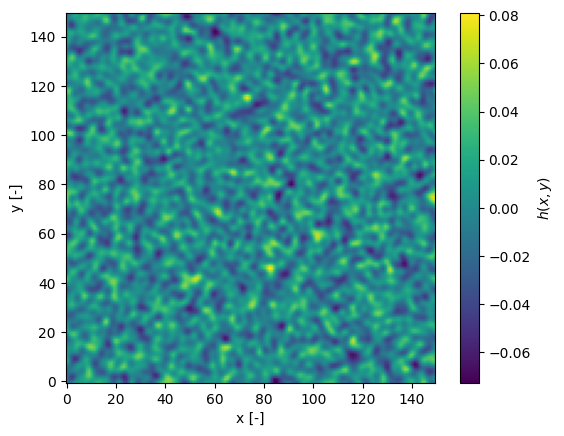

In [15]:
fig, ax = plt.subplots()

image = ax.imshow(surface, origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

Cut the surface to the desired dimensions in x (xpxl) and y (ypxl)

In [16]:
surface_cut = surface[0:ypxl_snow, 0:xpxl_snow]
print(surface_cut.shape)


(100, 150)


Check for minimum and set it to 0

In [17]:
srf_min = surface_cut.min()
print('minimum of surface = ', srf_min)
surface_cut = surface_cut - srf_min
print('maximum of surface = ', surface_cut.max())

minimum of surface =  -0.07166578956377054
maximum of surface =  0.1525703801034114


and check plot

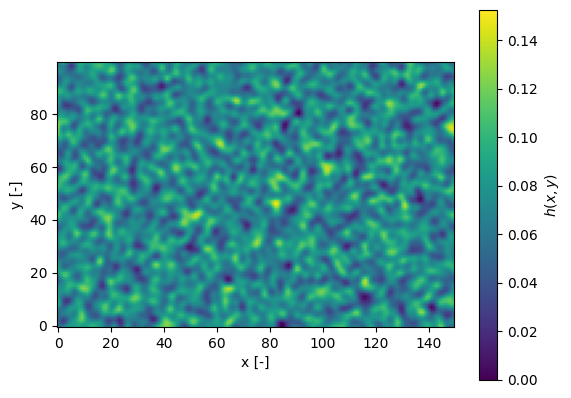

In [18]:
fig, ax = plt.subplots()

image = ax.imshow(surface_cut, origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

Plot histogram of heights

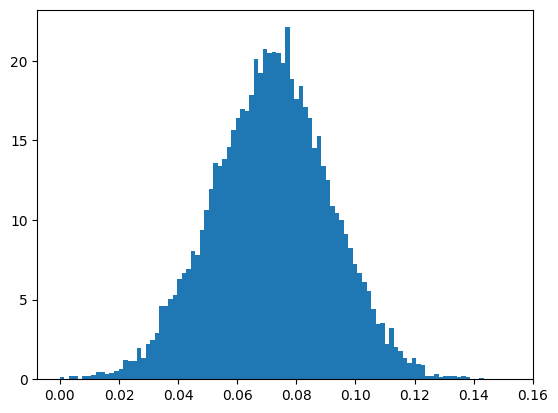

In [19]:
fig, ax = plt.subplots()

heights_tmp = numpy.concatenate(surface_cut)
image = ax.hist(heights_tmp, 100, density=True)

plt.show()

## Generate grass

Necessary code copied from above

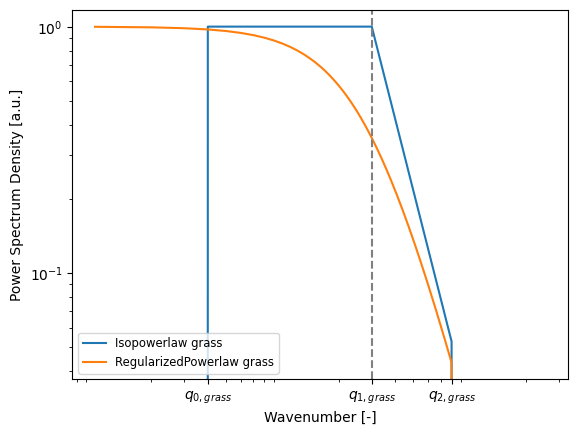

In [20]:
fig, ax = plt.subplots()

q0_grass = 4
q1_grass = 30
q2_grass = 80
H_grass = 0.5

def isopowerlaw_grass(q):
    if q < q0_grass:
        return 0.
    elif q > q2_grass:
        return 0.
    elif q < q1_grass:
        return 1.
    else:
        return (q / q1_grass)**-(2 * H_grass + 2)
    
def regularizedpowerlaw_grass(q):
    if q > q2_grass:
        return 0.
    else:
        return (1 + (q / q1_grass)**2)**-(H_grass + 1)
    
isopowerlaw_grass = numpy.vectorize(isopowerlaw_grass)
regularizedpowerlaw_grass = numpy.vectorize(regularizedpowerlaw_grass)
    
q_grass = numpy.arange(1, 256)

ax.plot(q_grass, isopowerlaw_grass(q_grass), label='Isopowerlaw grass')
ax.plot(q_grass, regularizedpowerlaw_grass(q_grass), label='RegularizedPowerlaw grass')
ax.axvline(q1_grass, color='gray', ls='--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([q0_grass, q1_grass, q2_grass])
ax.set_xticklabels(['$q_{0,grass}$', '$q_{1, grass}$', '$q_{2, grass}$'])

ax.set_xlabel('Wavenumber [-]')
ax.set_ylabel('Power Spectrum Density [a.u.]')

ax.legend(fontsize='small')
plt.show()

Create spectrum objects

In [21]:
spectrum_grass = tamaas.Isopowerlaw2D()
spectrum_grass.q0 = q0_grass
spectrum_grass.q1 = q1_grass
spectrum_grass.q2 = q2_grass
spectrum_grass.hurst = H_grass

rms_heights_grass = spectrum_grass.rmsHeights()
rms_slopes_grass  = spectrum_grass.rmsSlopes()

display(Latex(r'$\sqrt{{\langle h^2 \rangle}} \approx {:.0f}$'.format(rms_heights_grass)))
display(Latex(r'$\sqrt{{\langle \nabla h^2 \rangle}} \approx {:.0f}$'.format(rms_slopes_grass)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Creating the surface generator, generate it and plot

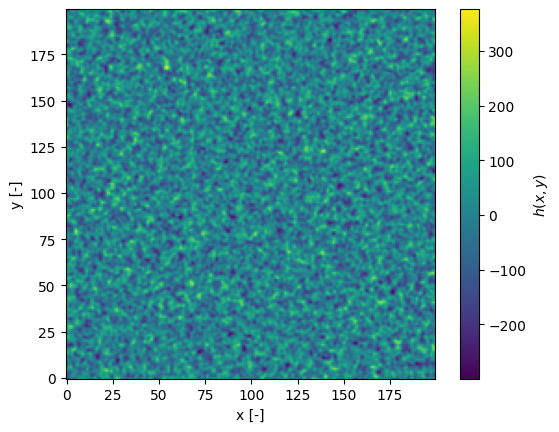

In [22]:
generator_grass = tamaas.SurfaceGeneratorRandomPhase2D([N_grass, N_grass])
generator_grass.spectrum = spectrum_grass
generator_grass.random_seed = 43

surface_grass = generator_grass.buildSurface()

fig, ax = plt.subplots()

image = ax.imshow(surface_grass, origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

Plot statistical properties

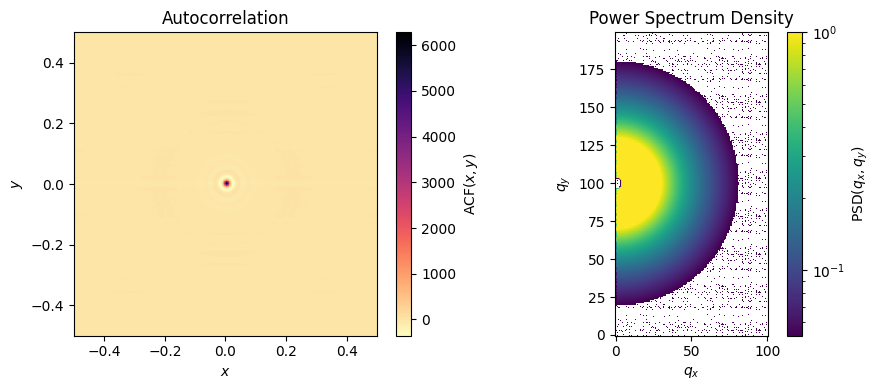

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

psd_grass = tamaas.Statistics2D.computePowerSpectrum(surface_grass)
acf_grass = tamaas.Statistics2D.computeAutocorrelation(surface_grass)

# Plot autocorrelation (we use fftshift to rearrange data)
image = axs[0].imshow(numpy.fft.fftshift(acf_grass), extent=(-0.5, 0.5, -0.5, 0.5),
                      origin='lower', cmap='magma_r')
fig.colorbar(image, ax=axs[0]).set_label('ACF$(x, y)$')
axs[0].set_title("Autocorrelation")
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')

# We use a logarithmic color scale
norm_grass = LogNorm(vmin=(q2_grass / q1_grass)**-(2 * H_grass + 2), vmax=1)
# Shift only along one axis due to r2c transform
image = axs[1].imshow(numpy.fft.fftshift(psd_grass, axes=0).real,
                      origin='lower', norm=norm_grass)
fig.colorbar(image, ax=axs[1]).set_label('PSD$(q_x, q_y)$')
axs[1].set_title('Power Spectrum Density')
axs[1].set_xlabel('$q_x$')
axs[1].set_ylabel('$q_y$')

fig.tight_layout()
plt.show()

and isotropic power law in 1D (by radially averaging the computed PSD)

0.0019218286059195537


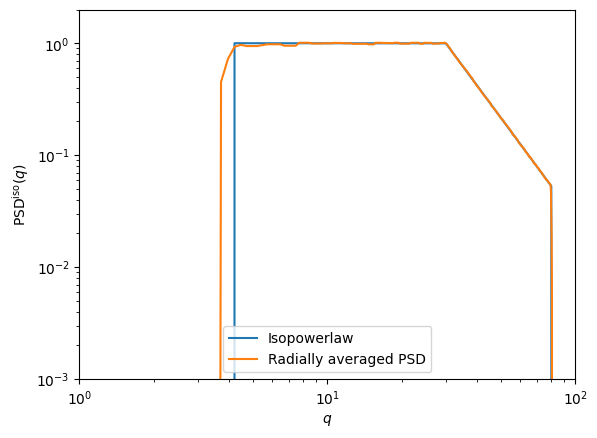

In [24]:
from tamaas.utils import radial_average

# Center PSD and select real values
psd_grass_ = numpy.fft.fftshift(psd_grass, axes=0).real

# Construct q-coordinate space
qx_grass = numpy.arange(-psd_grass_.shape[0] // 2, psd_grass_.shape[0] // 2)
qy_grass = numpy.arange(psd_grass_.shape[1])

# Construct polar coordinates (must be within the qx x qy domain)
r_grass = numpy.linspace(0, N_grass//2 - 1, N_grass * 2)
theta_grass = numpy.linspace(0, numpy.pi, 100)

# Do the radial average with nearest point interpolation
psd_iso_grass = radial_average(qx_grass, qy_grass, psd_grass_, r_grass, theta_grass, method='nearest')

fig, ax = plt.subplots()

# Plot theoretical PSD
ax.loglog(r_grass, isopowerlaw_grass(r_grass), label='Isopowerlaw')

# Plot averaged PSD
ax.loglog(r_grass, psd_iso_grass, label='Radially averaged PSD')

ax.set_xlim(1, N_grass // 2)
ax.set_ylim(1e-3, 2)

ax.set_xlabel("$q$")
ax.set_ylabel('PSD$^\\mathrm{iso}(q)$')

ax.legend()

print(numpy.mean((isopowerlaw_grass(r_grass)-psd_iso_grass)**2))

plt.show()

Normalizing and set to desired RMS and plot

<IPython.core.display.Latex object>

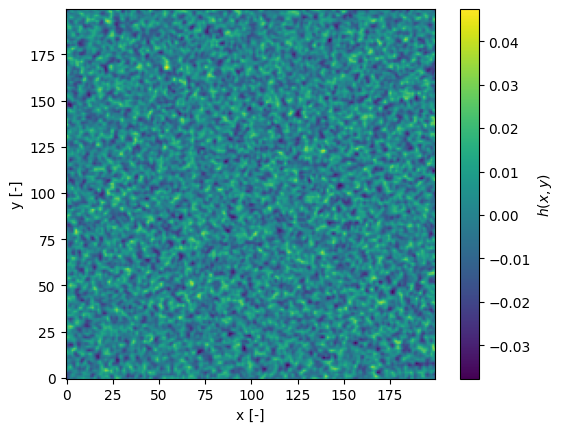

In [25]:
target_rms_heights_grass = 0.01

# Normalizing the surface with theoretical RMS heights
surface_grass *= target_rms_heights_grass / spectrum_grass.rmsHeights()

display(Latex(r'New $\sqrt{{\langle h^2 \rangle}} = {:.2f}$'.format(tamaas.Statistics2D.computeRMSHeights(surface_grass))))

fig, ax = plt.subplots()

image = ax.imshow(surface_grass, origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

Cut surface, and lift, so that minimum = 0

(100, 200)
minimum of surface =  -0.03773337356591363
maximum of surface =  0.0736846022403787


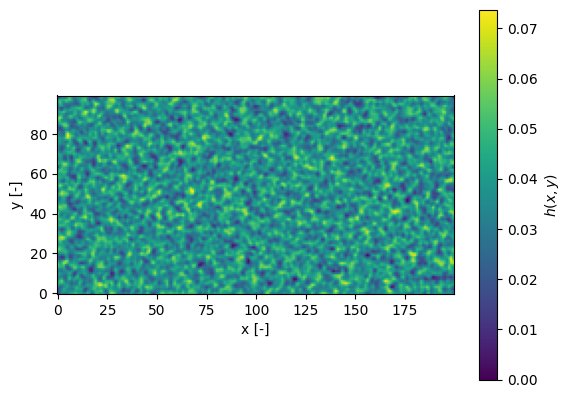

In [26]:
surface_grass_cut = surface_grass[0:ypxl_grass, 0:xpxl_grass]
print(surface_grass_cut.shape)

srf_grass_min = surface_grass_cut.min()
print('minimum of surface = ', srf_grass_min)
surface_grass_cut = surface_grass_cut - srf_grass_min
print('maximum of surface = ', surface_grass_cut.max())


fig, ax = plt.subplots()

image = ax.imshow(surface_grass_cut, origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

## Stitch Grass and Snow together

Stitch both arrays together

In [27]:
surface_grass_and_snow = numpy.concatenate((surface_grass_cut, surface_cut), axis=1)
print(surface_grass_and_snow.shape)

(100, 350)


Linearly dampen the transition from grass to snow

In [28]:
import math

bare_to_snow_transition = surface_grass_cut.shape[1]
#print(bare_to_snow_transition)

surface_final = numpy.copy(surface_grass_and_snow)

dampen_pxl = 3
#y=m*i+t
t = surface_final[:, bare_to_snow_transition-1]
m = (surface_final[:, bare_to_snow_transition+dampen_pxl-1] - surface_final[:, bare_to_snow_transition -1]) / dampen_pxl
for i in range(0,dampen_pxl):
    surface_final[:,bare_to_snow_transition - 1 + i] = m * i + t

surface_final.shape

(100, 350)

Cut domain for small trial runs

In [29]:
cutdomain = True

if cutdomain:
    surface_final = surface_final[20:80,120:320]
    xpxl_snow = 120
    xpxl_grass = 80
    ypxl = 60
    xlength = 20
    ylength = 6
    #stl_filename = '/home/haugened/Documents/openfoam/duerr_les/scripts/create_rough_surface/srf_medium.stl'

surface_final.shape

(60, 200)

smooth lateral boundaries and inflow if flag set in first cell

In [30]:
if lateralsmoothing:
    #y = m * i + t
    #boundary at y=0
    m = surface_final[lateralpxl-1, :]/lateralpxl
    for i in range(0, lateralpxl):
        surface_final[i,:] = m * i

    #boundary at y=yMax
    m = surface_final[-lateralpxl, :]/lateralpxl
    for i in range(0,lateralpxl):
        surface_final[-i-1,:] = m * i

#inflow
if inflowsmoothing:
    m = surface_final[:, inflowpxl-1]/inflowpxl
    for i in range(0, inflowpxl):
        surface_final[:, i] = m * i
   

and check plot

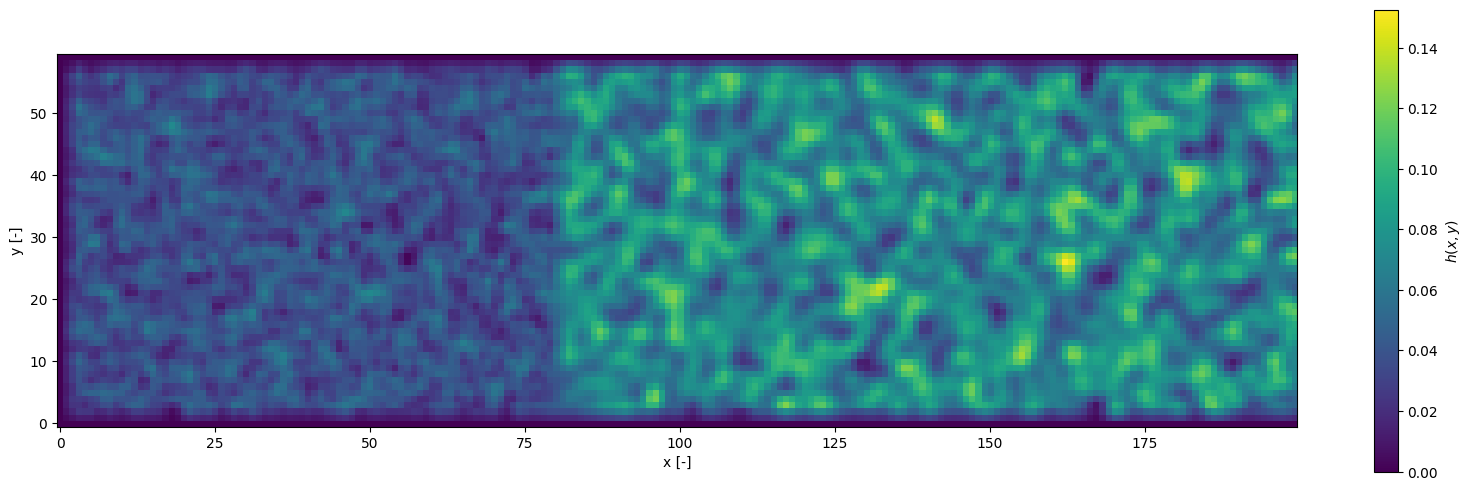

In [32]:
fig, ax = plt.subplots(figsize=(20,6))

image = ax.imshow(surface_final, origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

Export to stl using surf2stl (code copied from tutorial)

In [34]:
import surf2stl

# create x,y,z data for 3d surface plot
x = numpy.linspace(0, xlength, xpxl_snow+xpxl_grass)
y = numpy.linspace(0, ylength, ypxl)
X, Y = numpy.meshgrid(x, y)


# export surface to a stl format file
surf2stl.write(stl_filename, X, Y, surface_final)


Create a surface line at the cross section position

In [39]:
middle_idx = round(surface_final.shape[0]/2-1)
xline = surface_final[middle_idx, :]
xcross_out = numpy.zeros((xline.size, 2))
xcross_out[:, 0] = x
xcross_out[:, 1] = xline
#print(xcross_out[-10:-1,:])

numpy.savetxt('/home/haugened/Documents/openfoam/duerr_les/xcross_medium.csv', xcross_out, delimiter=',')   # X is an array

---------------------------------------------------------------------------------------------------
### From here on not used anymore

## Custom spectrum

Custom spectra objects can be created directly in Python by declaring a subclass to `tamaas.Filter2D`. This subclass will be queried for the Fourier coefficents of the power spectrum. For example, below is a class that computes these coefficents from a specified autocorrelation function.

In [40]:
class AutocorrelationFilter(tamaas.Filter2D):
    def __init__(self, autocorrelation):
        tamaas.Filter2D.__init__(self)
        self.autocorrelation = autocorrelation.copy()

    def computeFilter(self, filter_coefficients):
        shifted_ac = numpy.fft.ifftshift(self.autocorrelation)
        
        # Fill in the PSD coefficients
        filter_coefficients[...] = numpy.sqrt(numpy.fft.rfft2(shifted_ac))
        # Normalize
        filter_coefficients[...] *= 1 / numpy.sqrt(self.autocorrelation.size)

Let's create a surface with a gaussian autocorrelation.

In [41]:
sigma = 1e-4

x = numpy.linspace(-0.5, 0.5, N)
y = numpy.linspace(-0.5, 0.5, N)

xx, yy = numpy.meshgrid(x, y, indexing='ij')
acf = numpy.exp(- (xx**2 + yy**2) / (2 * sigma)) / (sigma * numpy.sqrt(2 * pi))

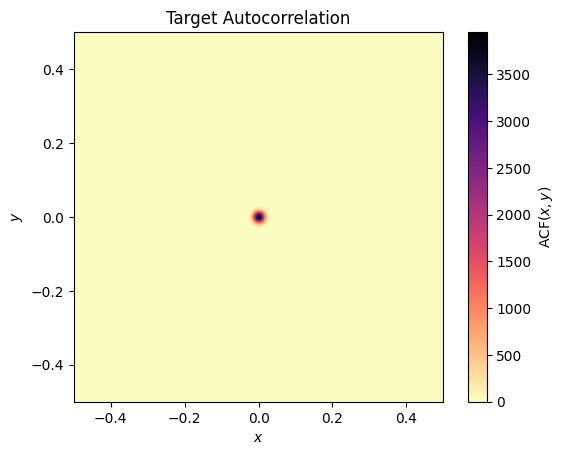

In [42]:
fig, ax = plt.subplots()

image = ax.imshow(acf, extent=(-0.5, 0.5, -0.5, 0.5), origin='lower', cmap='magma_r')
fig.colorbar(image).set_label("ACF($x, y$)")

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title("Target Autocorrelation")

plt.show()

In [43]:
spectrum = AutocorrelationFilter(acf)
generator.spectrum = spectrum
surface = generator.buildSurface()

ValueError: could not broadcast input array from shape (512,257) into shape (1000,501)

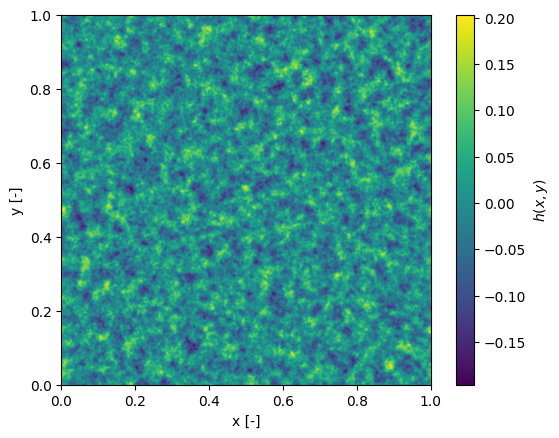

In [44]:
fig, ax = plt.subplots()

image = ax.imshow(surface, extent=(0, 1, 0, 1), origin='lower')
fig.colorbar(image).set_label('$h(x, y)$')

ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
plt.show()

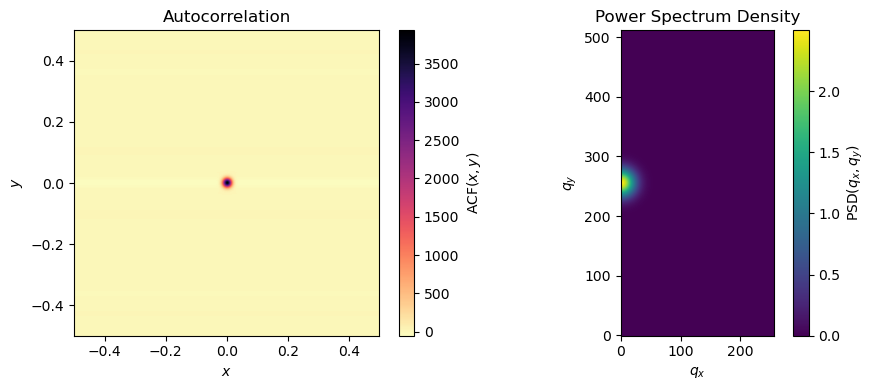

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

psd = tamaas.Statistics2D.computePowerSpectrum(surface)
acf = tamaas.Statistics2D.computeAutocorrelation(surface)

image = axs[0].imshow(numpy.fft.fftshift(acf), extent=(-0.5, 0.5, -0.5, 0.5),
                      origin='lower', cmap='magma_r')
fig.colorbar(image, ax=axs[0]).set_label('ACF$(x, y)$')
axs[0].set_title("Autocorrelation")
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')

image = axs[1].imshow(numpy.fft.fftshift(psd, axes=0).real,
                      origin='lower')
fig.colorbar(image, ax=axs[1]).set_label('PSD$(q_x, q_y)$')
axs[1].set_title('Power Spectrum Density')
axs[1].set_xlabel('$q_x$')
axs[1].set_ylabel('$q_y$')

fig.tight_layout()
plt.show()

We recover our input autocorrelation!